# Review type prediction notebook 
by-Realtime Dreamer team
-Suwasit Wittayawijug 

### Set up enviroment

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

!pip install transformers
!pip install torch
!pip install openpyxl
!pip install  altair_saver
!npm install vega-lite vega-cli canvas

Mounted at /content/drive
Wed Aug 17 16:33:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

### Define path for github repository

In [ ]:
path_src_data='src/data/'
path_src_models='src/models/'
path_visualization='src/visualization/'
path_data_raw='data/raw/'
path_data_processed='data/processed/'
path_data_interim='data/interim/'
path_data_external ='data/external/'
path_data_final ='data/final/'

### Helper(Utility) funtion 

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score
import torch as torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
import altair as alt
from altair_saver import save
import warnings
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, logging
from transformers import AutoModel, AutoTokenizer
alt.renderers.enable('default')


warnings.filterwarnings('ignore')
no_deprecation_warning=True




MAX_LEN = 768
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
label_dict={'Product':0, 'Quality':1, 'Logistic':2, 'Sale':3, 'Service':4}
label_dict_inverse = {v: k for k, v in label_dict.items()}


def import_review_data(df, sheet_name):
    df = pd.read_excel(
                        df,
                        engine='openpyxl',
                        sheet_name=sheet_name,
                        skiprows=0).rename(columns = {'Review Content' : 'content', 'Comment Type 1' : 'topics', 'Comment classified Type 1' : 'sentiment'})

    return df



def oversample_minority_class(df):

  print('original_shape',df.shape)
  df['content'] = df['content'].str.lower()
  df = df[['content', 'topics', 'sentiment']].dropna()

  class_names = list(df.topics.unique())
  def to_numeric(labels):
    return class_names.index(labels)

  possible_labels = df.topics.unique()
  label_dict = {}

  for index, possible_label in enumerate(possible_labels):
      label_dict[possible_label] = index

  df['labels'] = df.topics.apply(to_numeric)
  col_name1=df.columns
  add_3=  random.choices (df[df['labels']==3].values, k=1800)
  add_3_df = pd.DataFrame( add_3,columns=col_name1)
  add_4=  random.choices (df[df['labels']==4].values, k=1800)
  add_4_df = pd.DataFrame( add_4,columns=col_name1)
  df1=pd.concat([df, add_3_df, add_4_df], axis=0)

  print('oversample_shape', df1.shape)

  df=df1

  return df


def add_label_to_df(df):
    label_dict = {'positive': 2, 'neutral': 1, 'negative': 0}
    df['label'] = df['emotion'].replace(label_dict)
    df = df[['index', 'Vietnamese', 'emotion', 'label']]
    return df




def data_split(df):
  split_seed = 1
  df_train, df_test = train_test_split(df, test_size=0.2, random_state=split_seed)
  df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=split_seed)
  return df_train,df_val,df_test



def set_data_category_in_df(df):
    df_train,df_val,df_test = data_split(df)
    df_train['data_category'] = 'train'
    df_test['data_category'] = 'test'
    df_val['data_category'] = 'val'
    df= pd.concat([df_train,df_test,df_val], axis=0)
    print(df.head(5))
    return df



def encode_data_and_prepare_dataset(df, tokenizer):
    df = set_data_category_in_df(df)
    encoded_data_train = tokenizer.batch_encode_plus(df[df.data_category == 'train'].Vietnamese.values,
                                                     add_special_tokens=True,
                                                     return_attention_mask=True,
                                                     padding=True,
                                                     return_tensors='pt')

    encoded_data_val = tokenizer.batch_encode_plus(df[df.data_category == 'val'].Vietnamese.values,
                                                   add_special_tokens=True,
                                                   return_attention_mask=True,
                                                   padding=True,
                                                   return_tensors='pt')

    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(df[df.data_category == 'train']['label'].values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(df[df.data_category == 'val']['label'].values)

    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
    return dataset_train, dataset_val



def build_Bert_model(pre_trained_model, attention_probs_dropout_prob, hidden_dropout_prob):    
    label_dict={'Product':0, 'Quality':1, 'Logistic':2, 'Sale':3, 'Service':4}
    model = BertForSequenceClassification.from_pretrained(
                                          'vinai/phobert-base', 
                                          num_labels = len(label_dict),
                                          output_attentions = False,
                                          output_hidden_states = False
                                        )
    model = model.to(device)

    return model


def create_data_loader(df, tokenizer, max_len, batch_size):
  encoding = tokenizer.batch_encode_plus(
      df.content.to_numpy(),
      add_special_tokens=True,
      return_token_type_ids=False,
      return_attention_mask=True,
      padding=True,
      return_tensors='pt',
      max_length = max_len,
      truncation=True
    )
  dataset = TensorDataset(encoding['input_ids'],encoding['attention_mask'],torch.tensor(df.labels.to_numpy()))
 
  return DataLoader(
    dataset,
    sampler=RandomSampler(dataset),
    batch_size=batch_size  
    )
  

def setup_optimizer(model, Ir, eps):
    optimizer = AdamW(model.parameters(),
                      lr=Ir,
                      eps=eps)
    return optimizer


def setup_scheduler(dataloader_train, optimizer, epochs):
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(dataloader_train) * epochs)
    return scheduler


def evaluate(model, dataloader_validation):
    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_validation:
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2],
                  }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_validation)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals


def train_model_phobert(model, model_path ,pre_trained_model, model_type, Ir, eps, attention_probs_dropout_prob, hidden_dropout_prob, epochs,
                batch_size, dataloader_train, dataloader_validation, train_data_provider):
  tmp_loss = float('inf')
  epoch_list=[]
  train_loss=[]
  validation_loss=[]
  F1_score_weighted=[]
  F1_score_macro=[]
  F1_score_micro=[]
  optimizer1 = setup_optimizer(model, Ir, eps)
  for epoch in tqdm(range(1, epochs+1)):
      epoch_list.append(epoch)
      model.train()
      loss_train_total = 0
      
      progress_bar = tqdm(dataloader_train, 
                          desc='Epoch {:1d}'.format(epoch), 
                          leave=False, 
                          disable=False)
      
      for batch in progress_bar:
          model.zero_grad()
          batch = tuple(b.to(device) for b in batch)
          inputs = {
              'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]
          }
          
          outputs = model(**inputs)
          loss = outputs[0]
          loss_train_total +=loss.item()
          loss.backward()
          
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer1.step()

          
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
      

      
      tqdm.write('\nEpoch {epoch}')
      
      loss_train_avg = loss_train_total/len(dataloader_train)
      
      val_loss, predictions, true_vals = evaluate(model,dataloader_validation)
      val_f1_weighted = f1_score_func(predictions, true_vals,'weighted')
      val_f1_macro = f1_score_func(predictions, true_vals,'macro')
      val_f1_micro = f1_score_func(predictions, true_vals,'micro')

      train_loss.append(loss_train_avg)
      validation_loss.append(val_loss)
      F1_score_weighted.append(val_f1_weighted)
      F1_score_macro.append(val_f1_macro)
      F1_score_micro.append(val_f1_micro)

      if val_loss < tmp_loss:
        print('Save Model -----------------')
        torch.save(model, model_path)
        tmp_loss = val_loss

      

      tqdm.write(f'Training loss: {loss_train_avg}')
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'F1 Score (weighted): {val_f1_weighted}')
      tqdm.write(f'F1 Score (macro): {val_f1_macro}')
      tqdm.write(f'F1 Score (micro): {val_f1_micro}')

      eval_df=pd.DataFrame()
      eval_df['epoch'] = epoch_list
      eval_df['train_loss'] = train_loss
      eval_df['val_loss'] = validation_loss
      eval_df['F1_score_weighted'] = F1_score_weighted
      eval_df['F1_score_macro'] = F1_score_macro
      eval_df['F1_score_micro'] = F1_score_micro
      eval_df['batch_size'] = batch_size
      eval_df['Ir'] = Ir
      eval_df['eps'] = eps
      eval_df['pre_trained_model'] = pre_trained_model
      eval_df['hidden_dropout_prob'] = hidden_dropout_prob
      eval_df['attention_probs_dropout_prob'] = attention_probs_dropout_prob
      eval_df['note'] = 'Added and splited Self-judged Review emotions into train and valiation by 8:2'
      eval_df['train_data_creator'] = train_data_provider 

  return eval_df, model


def f1_score_func(preds, labels, average):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average=average)


def accuracy_per_class(preds, labels, model_type, epochs, train_data_provider):
    class_list = []
    score_list = []
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    print("Prediction accuracy for individual class:")
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        acc = len(y_preds[y_preds == label]) / len(y_true)
        class_list.append(label_dict_inverse[label])
        score_list.append(len(y_preds[y_preds == label]) / len(y_true))
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}, ', \
              '{:.3f}'.format(acc), '\n')
    df = pd.DataFrame(class_list, columns=['class'])
    df['score'] = score_list
    df['pre_trained_model'] = model_type
    df['epoch'] = epochs
    df['train_data_creator'] = train_data_provider
    return df


def predict_text(input_text, tokenizer, model):
    inputs = tokenizer(input_text.lower(), return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return label_dict_inverse[predicted_class_id]


def prepare_review_data(review_df):
    review_df = review_df.reset_index()
    review_df_1 = review_df[['index', 'Review Content', 'Rating']].dropna(how='any')
    print("raw review dataset after dropping null value:", review_df_1.shape)
    return review_df, review_df_1

def generate_predition_data(df):
    review_df, review_df1 = prepare_review_data(df)
    review_df1['emotion'] = review_df1['Review Content'].apply(predict_text)
    review_emotion_prediction = pd.merge(review_df, review_df1[['index', 'emotion']], how='left', on='index')
    return review_emotion_prediction




def draw_F1_scores(df, domain, width, height, first_line_title, second_line_title, epochs):
    if epochs == 1:
        base = alt.Chart(df).mark_point()
    else:
        base = alt.Chart(df).mark_line()

    graph = base.encode(
        x='epoch',
        y=alt.Y("value:Q", title="", scale=alt.Scale(domain=domain)),
        color=alt.Color('line type:N',
                        legend=alt.Legend(
                            title="Metrics",
                            orient='right',
                            titleFontSize=11,
                            titleColor='black',
                            labelFontSize=10.5,
                            labelColor='black',
                            direction='vertical')),
        tooltip=['emotion', 'epoch', 'line type', 'value']
    ).interactive(
    ).properties(
        width=width,
        height=height,
        title={"text": [first_line_title, second_line_title], "color": "black"})
    return graph


def draw_prediction_accuracy(df, domain, width, height, first_line_title, second_line_title):
    base = alt.Chart(df).mark_bar().encode(
        x=alt.X('class:N', axis=alt.Axis(labelAngle=360))
    ).properties(
        width=width,
        height=height,
        title={"text": [first_line_title, second_line_title], "color": "black"})

    graph = base.mark_bar(size=20).encode(
        y=alt.Y("score:Q", title="", scale=alt.Scale(domain=domain)),
        color=alt.Color('class:N', legend=None),
        tooltip=['pre_trained_model', 'class', 'score', 'epoch', 'train_data_creator']
    ).interactive()
    return graph


def prepare_data_for_metrics_graphs(df, best_epoch_F1_score_macro, best_model=False):
    df_f1_scores_id_vars = ['emotion', 'epoch', 'batch_size', 'Ir', 'eps', 'pre_trained_model', 'hidden_dropout_prob',
                            'attention_probs_dropout_prob', 'note', 'train_data_creator']
    df_f1_scores_value_vars = ['train_loss', 'val_loss', 'F1_score_weighted', 'F1_score_macro', 'F1_score_micro']


    df_f1_scores_var_name = ['line type']
    if best_model:
        df_f1_scores = df[df['epoch'] <= best_epoch_F1_score_macro]
    else:
        df_f1_scores = df.copy()
    df_f1_scores_long = pd.melt(df_f1_scores,
                                id_vars=df_f1_scores_id_vars,
                                value_vars=df_f1_scores_value_vars,
                                var_name=df_f1_scores_var_name)
    return df_f1_scores_long


def prepare_metrics_graphs(df_f1_scores_long, df_class_accuracy, domain, width, height, epochs):
    F1_scores_graph = draw_F1_scores(df_f1_scores_long,
                                     domain,
                                     width,
                                     height,
                                     "F1 scores (Macro, Micro, Weighted)",
                                     "Train loss, Validation loss",
                                     epochs)

    prediction_accuracy_graph = draw_prediction_accuracy(df_class_accuracy,
                                                         domain,
                                                         width,
                                                         height,
                                                         "Accuracy Per Class",
                                                         "Pre-Trained Model: " \
                                                         + df_class_accuracy['pre_trained_model'][1])
    return F1_scores_graph, prediction_accuracy_graph

def confusion_matrix_function (true_test,predictions):
  from sklearn.metrics import multilabel_confusion_matrix
  from sklearn.metrics import confusion_matrix

  class_list = ['Product', 'Quality', 'Logistic', 'Sale', 'Service']
  confusion1= confusion_matrix(true_test, np.argmax(predictions, axis=1).flatten())

  ConfusionMatrixDisplay.from_predictions(true_test, np.argmax(predictions, axis=1), cmap= 'Blues', colorbar = False, display_labels = class_list)
  plt.tight_layout()
  plt.subplots_adjust(wspace = 0.40, hspace = 0.1)
  plt.savefig(path_visualization+'confusion_phobert.png')
  return confusion1

def build_df__phobert_comparision(eval_df):

  train_pipeline_df=eval_df

  phobert_df_task1=pd.read_csv(path_data_external+'phobert1_eval_df_.csv')
  phobert_df_task1['epoch']=range(1,21)
  phobert_df_task1['table id']=1

  phobert_df_task2=pd.read_csv(path_data_external+'phobert2_eval_df_.csv')
  phobert_df_task2['epoch']=range(1,21)
  phobert_df_task2['table id']=2

  phobert_df_task3=pd.read_csv(path_data_external+'phobert3_eval_df_.csv')
  phobert_df_task3['epoch']=range(1,21)
  phobert_df_task3['table id']=3

  phobert_df_task4=pd.read_csv(path_data_external+'phobert3_dropout_eval_df_.csv')
  phobert_df_task4['epoch']=range(1,21)
  phobert_df_task4['table id']=4

  train_pipeline_df=train_pipeline_df.drop(['train_data_creator', 'note'], axis=1)
  train_pipeline_df['table id']=5
  df_combined=pd.concat([phobert_df_task1,phobert_df_task2,phobert_df_task3,phobert_df_task4,train_pipeline_df ])


  df_combined_long=pd.melt(df_combined, id_vars=[ 'epoch','batch_size', 'Ir', 'eps',
        'pre_trained_model', 'hidden_dropout_prob',
        'attention_probs_dropout_prob',  'table id'], value_vars=['train_loss', 'val_loss', 'F1_score_weighted',
        'F1_score_macro', 'F1_score_micro'],var_name=['line type'])

  return df_combined_long


  

def draw_graph( df,domain,table_id,width,height,scheme_name, 
               first_line_title,second_line_title,third_line_title,four_line_title,five_line_title):

    df=df[df['table id']==table_id]
    base = alt.Chart(df).mark_line().encode(
        x='epoch'
    ).properties(
        width=width,
        height=height,
        title={
          "text": [first_line_title,second_line_title,third_line_title,four_line_title,five_line_title], 

          "subtitle": ["", ""],
          "color": "black",
          "subtitleColor": "black",
        'anchor': 'middle',
        'fontSize': 15,
        'subtitleFontSize': 10,
        'offset': 1,
        }
    )
    graph=base.mark_line().encode(
        y=alt.Y("value:Q",title="",scale=alt.Scale(domain=domain)),
        color=alt.Color('line type:N',
                        legend=alt.Legend(
                        orient='bottom',
                        titleFontSize=11,
                        titleColor='black',
                        labelFontSize=15,
                        labelColor='black',
                        direction='horizontal'
                        )
                       ),
        tooltip=['epoch','line type','value']
        ).interactive()
    return graph

def combined_graph(df):
    width=300
    height=300
    scheme_name='greens'
    domain=(0,1.2)
    graph1=draw_graph(df,domain,1,width,height,scheme_name,'Model1','Phubert_1', 'Full data','dropout 0.1' ,"")
    graph2=draw_graph(df,domain,2,width,height,scheme_name,'Model2','Phubert_1', 'Group_class', 'droup 0.1' ,"")
    graph3=draw_graph(df,domain,3,width,height,scheme_name,'Model3','Phubert_1', 'Remove_class','dropout 0.1' ,"")
    graph4=draw_graph(df,domain,4,width,height,scheme_name,'Model4','Phubert_1', 'Remove_class','dropout 0.4' ,"")
    graph5=draw_graph(df,domain,5,width,height,scheme_name,'Model5','Phubert_1', 'upsample_minority_class','dropout 0.4' ,"")

    
    title=alt.Chart({"values": [{"text": "Model Evaluation"}]}).mark_text(
    size=15,dx=370,dy=0,color="black").encode(text='text:N').properties(width=width,height=10)
    
    chart= (graph1 | graph2 | graph3| graph4| graph5 ).configure_view(
        stroke=None
    ).configure_concat(
        spacing=6
    ).configure_title(fontSize=10.5)
    

    return chart


def load_accu_to_df(data,method):
    load_data = pickle.load(open(data , 'rb'))
    data_frame_load= load_data[['algorithms',  'accuracy',
           'precision', 'recall', 'f1_score']]
    data_frame_load['data_method']= method
    data_frame_load['algorithm_method'] = data_frame_load[["algorithms", "data_method"]].apply("-".join, axis=1)
    return data_frame_load

def build_traditional_chart (chart_df ):
  base = alt.Chart(chart_df).mark_bar().encode(
      x='algorithm_method:N',
      y= alt.Y('f1_score:Q', scale=alt.Scale(domain=(0,1.1))),
      color= 'algorithms:N',
      tooltip=['f1_score']
    )
      
  text= base .mark_text(dy= -10 ).encode(
      x='algorithm_method:N',
      text= alt.Text( 'f1_score:Q',format='.2f' ),

  )

  chart= (base+text).properties(width=600).configure_axis(
      labelFontSize=15,
      titleFontSize=15).interactive()
  return chart

def compare_tranditional():
  performance_df_all = path_data_external+'df__phobert_all.sav'
  performance_df_grouped = path_data_external+'df__phobert_grouping.sav'
  performance_df_remove = path_data_external+'df_phobert_remove.sav'
  performance_df_all_upsampling= path_data_external+'df__phobert_all_upsamples.sav'
  traditional_df_all=  path_data_external+'df_predict_all.sav'
  traditional_df_upsampling= path_data_external+ 'df_predict_upsampling.sav'
  traditional_df_group = path_data_external+'df_predict_grouping.sav'
  traditional_df_remove= path_data_external+'df_predict_remove.sav'

  model_list=[performance_df_all,performance_df_grouped,performance_df_remove,performance_df_all_upsampling,traditional_df_all,traditional_df_upsampling,traditional_df_group,traditional_df_remove]
  method_list=['all','grouped','removed','upsampling','all','upsampling','grouped','removed']

  df_out=pd.DataFrame()
  for i,model in enumerate(model_list):
      df_temp = load_accu_to_df(model,method_list[i])
      df_out = pd.concat([df_temp,df_out])

  all_model=df_out

  chart_df=all_model[all_model['data_method']!='grouped']
  return build_traditional_chart (chart_df)

### Step1 :Load/Clean/ Prepare_review_label

In [ ]:
input_file= path_data_raw+'Reviews.xlsx'
import_data = import_review_data(input_file, 'Database_LZD')
output_data = oversample_minority_class(import_data)

### Step2 : Split data to Train/Test/Validate sets

In [ ]:
data_category_df = set_data_category_in_df(output_data)


original_shape (26612, 19)
oversample_shape (15730, 4)
                                                 content    topics sentiment  \
6970                           sp tốt, hợp với giá tiền.   Quality      Good   
1775   shop làm ăn như shit nha các bạn bán hàng khôn...      Sale       Bad   
23459                   hàng rất chất lượng, gói hàng kỹ   Product      Good   
17841  hàng rất tuyệt vời, đóng gói cẩn thận. anh shi...  Logistic      Good   
17214                      vừa đập hộp xong đã thấy hư r   Quality       Bad   

       labels data_category  
6970        1         train  
1775        3         train  
23459       0         train  
17841       2         train  
17214       1         train  


### Step3: Train Phobert Model 

In [ ]:

MAX_LEN = 256
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hidden_dropout_prob = 0.4
attention_probs_dropout_prob = 0.1
pre_trained_model = 'vinai/phobert-base'
model_type = pre_trained_model.split('/')[0]
batch_size = 8
epochs = 1
Ir = 1e-5
eps = 1e-8
train_data_provider = 'Suwasit'

reviews_label_df = data_category_df 
df_train=reviews_label_df[reviews_label_df.data_category=='train']
df_test=reviews_label_df[reviews_label_df.data_category=='test']
df_val=reviews_label_df[reviews_label_df.data_category=='val']

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

dataloader_train= create_data_loader(df_train, tokenizer, MAX_LEN, batch_size)
dataloader_validation = create_data_loader(df_val, tokenizer, MAX_LEN, batch_size)
dataloader_test = create_data_loader(df_test, tokenizer, MAX_LEN, batch_size)

model = build_Bert_model(pre_trained_model, attention_probs_dropout_prob, hidden_dropout_prob)
model_path =  path_data_final+'reviewtype_phobert_model.pt'
torch.save(model.state_dict(), model_path)

eval_df, model = train_model_phobert(model, model_path,pre_trained_model, model_type, Ir, eps, attention_probs_dropout_prob, hidden_dropout_prob,
                                  epochs, batch_size, dataloader_train, dataloader_validation, train_data_provider)
eval_df_path = path_data_interim=+'reviewtype_pho_bert_eval_df.csv'
eval_df.to_csv(eval_df_path , index=False)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing BertForSequenceClassification: ['roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.8.attention.output.dense.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.5.attention.self.key.bias', 'roberta.encoder.layer.7.intermediate.dense.bias', 'roberta.encoder.layer.2.attention.self.key.bias', 'roberta.encoder.layer.1.attention.self.value.bias', 'roberta.encoder.layer.2.output.dense.bias', 'lm_head.decoder.weight', 'roberta.encoder.layer.4.attention.output.dense.bias', 'roberta.encoder.layer.9.output.dense.bias', 'roberta.encoder.layer.4.intermediate.dense.

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1259 [00:00<?, ?it/s]


Epoch {epoch}
Save Model -----------------
Training loss: 0.8474015363205796
Validation loss: 0.47827436642514337
F1 Score (weighted): 0.8292918665355007
F1 Score (macro): 0.8150092037149514
F1 Score (micro): 0.833134684147795


### Step4: Validate the model 

Prediction accuracy for individual class:
Class: Product
Accuracy: 1078/1158,  0.931 

Class: Quality
Accuracy: 683/834,  0.819 

Class: Logistic
Accuracy: 310/385,  0.805 

Class: Sale
Accuracy: 337/371,  0.908 

Class: Service
Accuracy: 327/398,  0.822 

[[1078   60   16    3    1]
 [  66  683   79    2    4]
 [  49   24  310    0    2]
 [   8   26    0  337    0]
 [   5    5   58    3  327]]


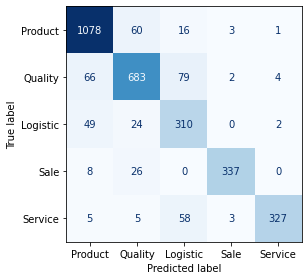

In [ ]:
model = torch.load(model_path)
_, predictions, true_vals = evaluate(model,dataloader_test)
accuracy_per_class_df = accuracy_per_class(predictions, true_vals, model_type, epochs, train_data_provider)
accuracy_per_class_df_path = path_data_final+'reviewtype__accuracy_per_class_df.csv'  
accuracy_per_class_df.to_csv(accuracy_per_class_df_path, index=False)
true_vals= true_vals.reshape(-1)
confusion_chart=confusion_matrix_function (true_vals,predictions)
print(confusion_chart)
best_epoch_F1_score_macro = eval_df[eval_df['F1_score_macro'] == max(eval_df['F1_score_macro'])]['epoch'].values[0]

### Step 5: Test the model with manaul Text input

In [ ]:
#reviewType_text_test_prediction.

def predict_text(input_text):
  inputs = tokenizer(input_text.lower(), return_tensors = "pt").to(device)
  with torch.no_grad():
      logits = model(**inputs).logits

  predicted_class_id = logits.argmax().item()
  return label_dict_inverse[predicted_class_id]


model.eval()
input_text='Sản phẩm rất tốt, và mạnh mẽ'
print("Predict review type : ",predict_text(input_text ))


Predict review type :  Quality


### Step6: Comparing the model performance with other models with difference hyper parameter tuning

In [ ]:
#reviewType_Chart1_tuning

model_compare_df = build_df__phobert_comparision(eval_df)
model_compare_chart= combined_graph(model_compare_df)
save(model_compare_chart, path_visualization+'reviewType_model_compare.png')
print('Model comparison chart is saved ,please check')
model_compare_chart


Model comparison chart is saved ,please check


alt.HConcatChart(...)

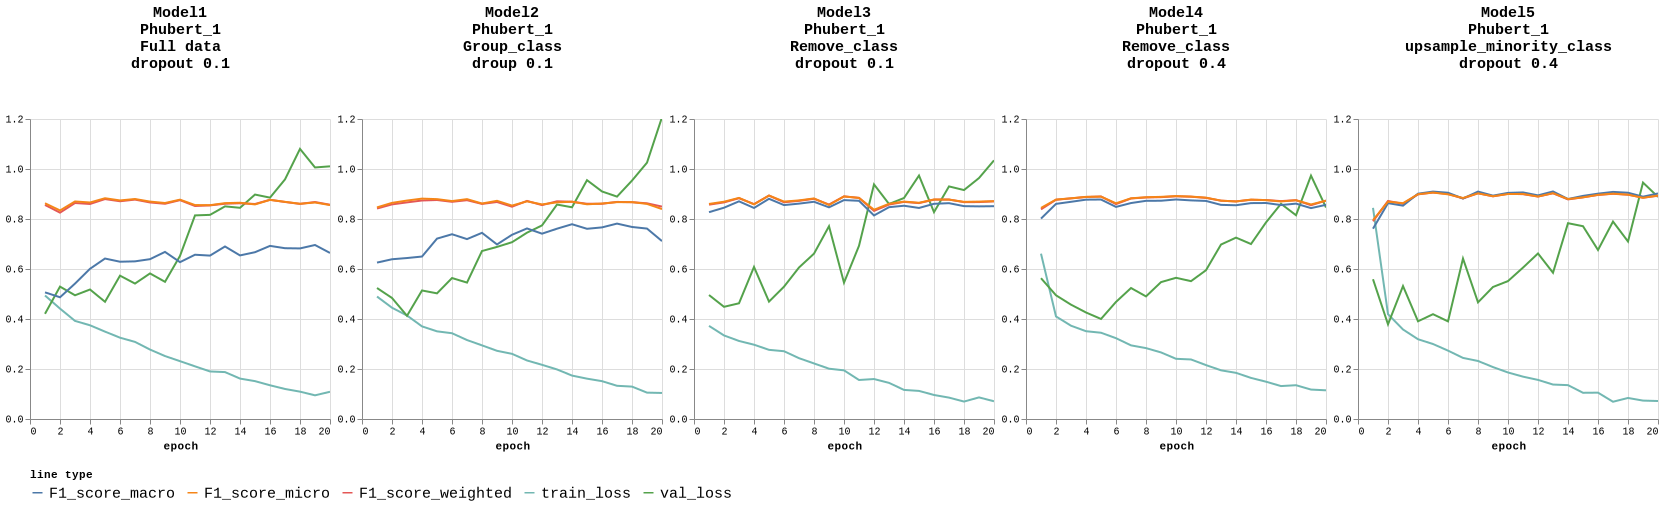

In [ ]:
#reviewType_Chart2_compare_traditional.
model_compare_chart = compare_tranditional()   
save(model_compare_chart, path_visualization+'reviewType_model_compare_traditional.png')
print('The comparison chart is now ready..please check.')
model_compare_chart

WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


The comparison chart is now ready..please check.


alt.LayerChart(...)

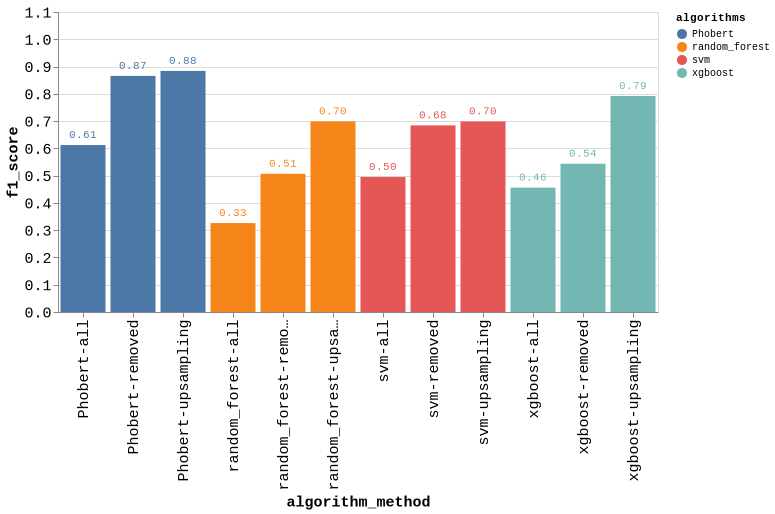